# A Large-Scale Fish Dataset

Link to Kaggle dataset:
https://www.kaggle.com/crowww/a-large-scale-fish-dataset
I divided manually in train, validation and test, and I uploaded on my GDrive.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_dir = "/content/drive/My Drive/Fish Dataset/"
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Import Torch
import torch
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [ ]:
# Imports
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from random import shuffle
import numpy as np
%matplotlib inline

In [ ]:
from torchvision import transforms

# Compose transformations
data_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.ToTensor(),
])

I will use ImageFolder to load images. ImageFolder returns: (sample, target) where target is class_index of the target class. Classes are taken from the name of the folders

In [ ]:
# Instantiate datasets
train_set = ImageFolder(os.path.join(root_dir, "train"), transform=data_transform)
val_set = ImageFolder(os.path.join(root_dir, "validation"), transform=data_transform)
test_set = ImageFolder(os.path.join(root_dir, "test"), transform=data_transform)

Some information about the dataset and the classes

In [ ]:
# Get number of classes (we'll need it in the model)
num_classes = len(train_set.classes)
# Print dataset statistics
print(f"Num. classes: {num_classes}")
print(f"Classes:\n {train_set.classes}")
print(f"Num. train samples: {len(train_set)}")
print(f"Num. valid. samples: {len(val_set)}")
print(f"Num. test samples: {len(test_set)}")

Num. classes: 9
Classes:
 ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
Num. train samples: 7200
Num. valid. samples: 903
Num. test samples: 900


In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 7200
    Root location: /content/drive/My Drive/Fish Dataset/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           )

Tensor of one sample (change 0 to see other samples)

In [ ]:
img_x, label_x = train_set[0]
print(img_x.shape, label_x)
img_x

torch.Size([3, 445, 590]) 0


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

Let's define a function to visualize some images:

In [ ]:
def show_example(img, label):
    print('Label: ', train_set.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Change 0 to visualize other samples

Label:  Black Sea Sprat (0)


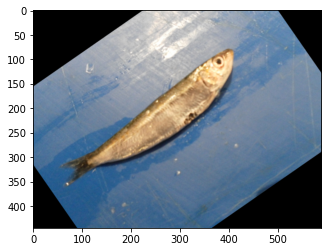

In [ ]:
show_example(*train_set[0])

Label:  Shrimp (6)


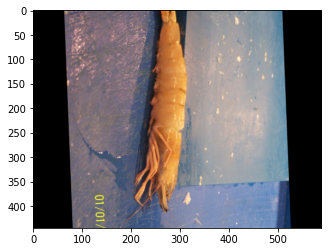

In [ ]:
show_example(*train_set[5000])

DataLoader of the 3 datasets:

In [ ]:
# Define loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=64, num_workers=2, drop_last=True, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=64, num_workers=2, drop_last=False, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=64, num_workers=2, drop_last=False, shuffle=False)

Let's create a simple model without FC, and then see the output dimension of the convolutional layers:

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=0, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


Our 2D CNN model expects as input a tensor of shape: [N, C, H, W], where:

*   N is the number of samples (batch_size);
*   C is the number of channels (1 for grayscale images, 3 for RGB images);
H and W are height and width dimension of the images;

*   H and W are height and width dimension of the images;

We have to add the batch dimension to test_x


In [ ]:
img_x = img_x.unsqueeze(dim=0)
img_x.size()

torch.Size([1, 3, 445, 590])

In [ ]:
output = model(img_x)
output.shape

torch.Size([1, 16, 109, 145])

In [ ]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

252880


So, this number, 252880 is the number of features of input for the first FC.

In [ ]:
class CNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=0, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(252880, 4096),
        nn.ReLU(),
        nn.Linear(4096, 1024),
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(1024, 9)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model
model = CNN()
output = model(img_x)
output.shape

torch.Size([1, 9])

In [ ]:
torch.cuda.is_available()

True

In [ ]:
dev = torch.device('cuda')
print(dev)

cuda


In [ ]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

Let's train the model for 10 epochs. We will search for the best validation accuracy.

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=252880, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=9, bias=True)
  )
)
Epoch 1: TrL=0.5469, TrA=0.8170, VL=0.3010, VA=0.9124, TeL=0.4250, TeA=0.8500,
Epoch 2: TrL=0.0503, TrA=0.9884, VL=0.1440, VA=0.9592, TeL=0.2551, TeA=0.9031,
Epoch 3: TrL=0.0143, TrA=0.9979, VL=0.2477, VA=0.9153, TeL=0.2624, TeA=0.9104,
Epoch 4: TrL=0.0130, TrA=0.9968, VL=0.1072, VA=0.9698, TeL=0.1

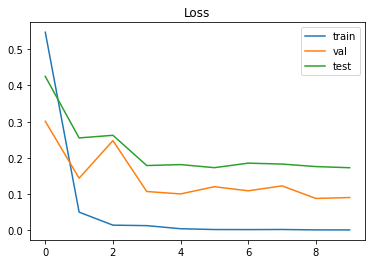

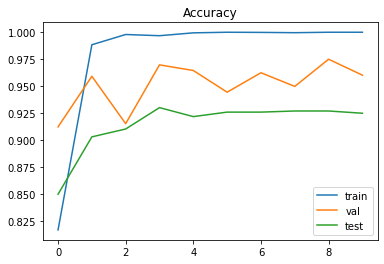

In [ ]:
# Train model
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)

The best model is at epoch 9 with a Validation accuracy of 97.5%

Define a function for visualizing predictions:

In [ ]:
def predict_image(img, model):
    # Get predictions from model
    img = (img.unsqueeze(dim=0)).to(dev)
    yb = model(img)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_set.classes[preds[0].item()]

An example of an image correctly classified:

Label: Black Sea Sprat , Predicted: Black Sea Sprat


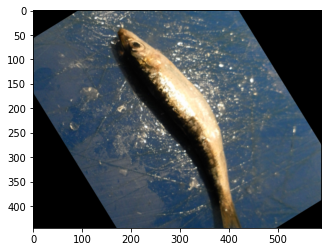

In [ ]:
img, label = test_set[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

An example of misclassified image:

Label: Shrimp , Predicted: Sea Bass


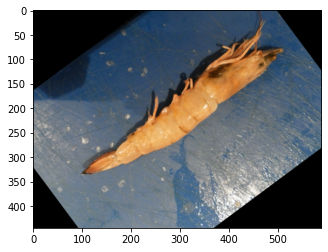

In [ ]:
img, label = test_set[634]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Save the model:

In [ ]:
model_save_name = '2C_Classifier.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)